In [1]:
# Librerias necesarias
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from datetime import datetime
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Resizing, UpSampling2D
from tensorflow.keras.layers import  Flatten, Dense,BatchNormalization,MultiHeadAttention, LayerNormalization, Permute, Add,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam
from skimage import exposure
from PIL import Image
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt


## ETAPA DE PREPROCESAMIENTO

In [2]:

# Define las rutas a las carpetas
base_dir = 'dataset'
categorias = ['normal','benigno', 'maligno']

datos = []
etiquetas = []
desviacion_estandar_antes = []
desviacion_estandar_despues = []

In [3]:
image_path = "../datasets/dataset/normal/imagenmdb_1220.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)

In [4]:
def read_imageResize_with_labels(dir='..\datasets\dataset',target_size = (224,224)):
    """
    Lee imágenes de un directorio, las redimensiona a 224x224 píxeles y las etiqueta según 
    la subcarpeta en la que se encuentran. Las imágenes son procesadas en escala de grises.

    Parámetros:
    dir (str): La ruta del directorio principal que contiene las subcarpetas con las imágenes. 
               Las subcarpetas deben llamarse 'normal', 'benigno' y 'maligno' para que 
               las etiquetas se asignen correctamente. Las subcarpetas no definidas 
               recibirán una etiqueta de -1.

    Retorno:
    tuple: Una tupla que contiene dos elementos:
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - list: Una lista de etiquetas correspondientes a las imágenes.
    """
    labels = []
    imgs = []
    for subfolder in os.listdir(dir):
        
        subfolder_path = os.path.join(dir,subfolder)
        for name_image in os.listdir(subfolder_path):
            # Obtener la etiqueta desde el nombre de la subcarpeta
            if subfolder == 'normal':
                labels.append(0)
            elif subfolder == 'benigno':
                labels.append(1)
            elif subfolder == 'maligno':
                labels.append(2)
            else:
                labels.append(-1)  # Etiqueta para casos no definidos

            # Obtenemos la ruta de la imagen
            image_path = os.path.join(subfolder_path,name_image)
            
            # Read the image using TensorFlow for GPU acceleration
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            #image = tf.image.decode_jpeg(image, channels=1)  # Leer en escala de grises
            #image = tf.image.convert_image_dtype(image, dtype=tf.float32)

            # Resize the image
            image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        
            imgs.append(image)
    
    return  np.array(imgs), labels

In [5]:
def img_compar(img_original, img_preprocess):
    '''
    Funcion utilizada para comparar la imagen antes y despues del procesmiento
    
    Parametros: 
    - img_original: imagen antes del procesamiento
    - img_preprocess: imagen procesada
    
    Output: La funcion muestra una figura de matplotlib con la imagen original y procesada
    '''
    # Mostrar la imagen original y la imagen preprocesada
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(img_preprocess, cmap='gray')
    plt.title('Imagen Preprocesada')
    plt.axis('on')

    plt.show()

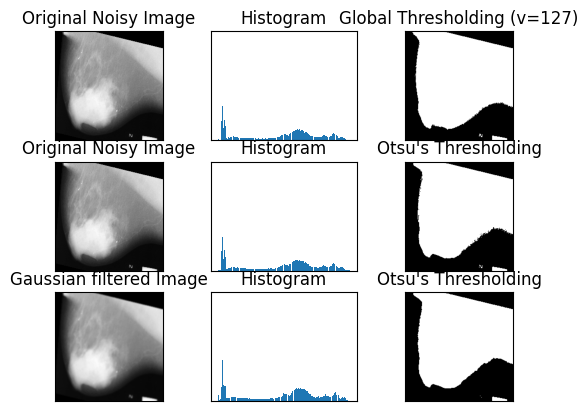

In [6]:
# global thresholding
ret1,th1 = cv2.threshold(img,60,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
 img, 0, th2,
 blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
 'Original Noisy Image','Histogram',"Otsu's Thresholding",
 'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
 plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
 plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
 plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
 plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

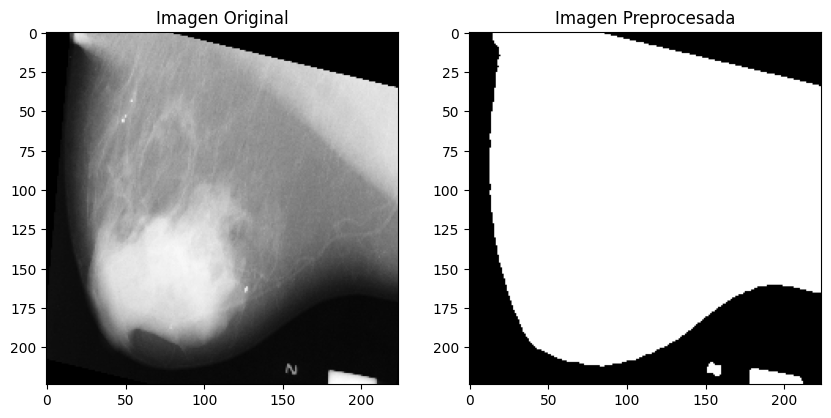

In [7]:
def gaussian_and_tresholdA(img, gaussian_kernel_size=(5,5),adaptive_thresh_blocksize=11, adaptive_thresh_C=2):
    """
    Aplica un filtro gaussiano para suavizar una imagen y luego aplica un umbral binario.

    Parametros:
        img (numpy.ndarray): La imagen de entrada.
        gaussian_kernel_size (tuple, opcional): Tamaño del kernel gaussiano. Por defecto es (5, 5).
        adaptive_thresh_blocksize (int, opcional): Tamaño del bloque para la umbralización adaptativa. Por defecto es 11.
        adaptive_thresh_C (int, opcional): Constante substraída en la umbralización adaptativa. Por defecto es 2.

    Retorno:
        numpy.ndarray: La imagen con umbral binario aplicado.
    """
    
    # Aplicar un filtro gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(img, gaussian_kernel_size, 0)
    
    # Aplicar umbralización adaptativa para resaltar las regiones de interés
    #adaptive_threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              # cv2.THRESH_BINARY_INV, adaptive_thresh_blocksize, adaptive_thresh_C)
    #_, otsu_threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    _,th1 = cv2.threshold(blurred,25,255,cv2.THRESH_BINARY)

    return th1

gaus_thres_img = gaussian_and_tresholdA(img)

img_compar(img,gaus_thres_img)
                                               

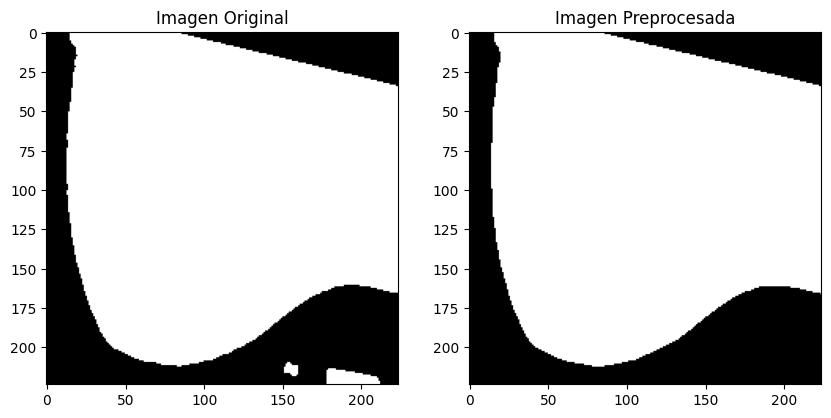

In [8]:
def filter_morph_open(img,morph_kernel_size=(30,30)):
    
    """
    Aplica una operación morfológica para eliminar pequeños artefactos de una imagen.

    Args:
        img (numpy.ndarray): La imagen de entrada.
        morph_kernel_size (tuple, opcional): Tamaño del kernel morfológico. Por defecto es (30, 30).

    Returns:
        numpy.ndarray: La imagen con la operación morfológica aplicada.
    """

    # Aplicar operación morfológica para eliminar pequeños artefactos blancos
    morph_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, morph_kernel)
    #morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, morph_kernel)

    return morphed

morphed_img = filter_morph_open(gaus_thres_img)

img_compar(gaus_thres_img,morphed_img)

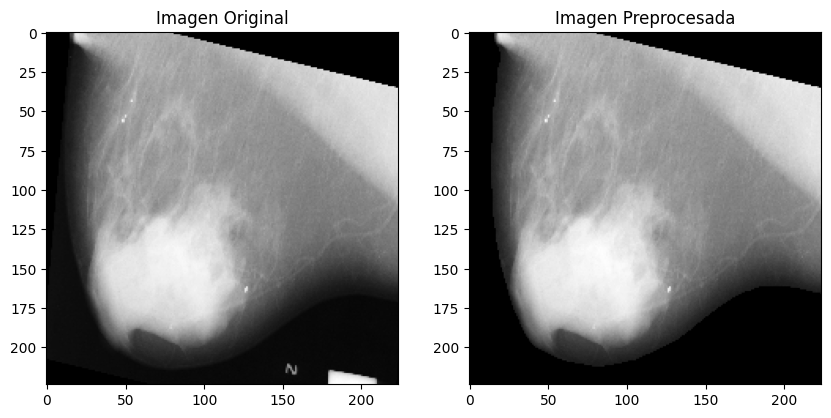

In [9]:
def extract_largest_component(morphed,gaus_thres_img,original):
    
    """
    Encuentra el componente conectado más grande (asumido como el seno) en la imagen morfológicamente procesada 
    y lo extrae de la imagen original.

    Args:
        morphed (numpy.ndarray): Imagen procesada morfológicamente.
        gaus_thres_img (numpy.ndarray): Imagen con filtro haussiano y threshold.
        original (numpy.ndarray): Imagen original.

    Returns:
        numpy.ndarray: Imagen original con solo el componente más grande conservado.
    """
     # Encontrar todos los componentes conectados
    num_labels, labels_im = cv2.connectedComponents(morphed)

    #print("numero de componentes: ",num_labels)
    #print("labels img: ",labels_im)
    
    # Eliminar componentes conectados pequeños (asumimos que el seno es el componente más grande)
    unique, counts = np.unique(labels_im, return_counts=True)

    #print("unique components: ",unique)
    #print("counts : ",counts)
    #print("fondo: " ,counts[0])
    # Ignorar el fondo
    counts[0] = 0
    
    # Encontrar el componente más grande
    max_label = unique[np.argmax(counts)]

    #print("componente mas grande: ",max_label)
    
    # Crear una máscara solo con el componente más grande
    cleaned_background = np.zeros(gaus_thres_img.shape, np.uint8)

    cleaned_background[labels_im == max_label] = 255
    
    # Aplicar la máscara para mantener solo el objeto principal
    cleaned_image = cv2.bitwise_and(original, original, mask=cleaned_background)

    return cleaned_image

nose_img = extract_largest_component(morphed_img,gaus_thres_img,img)

img_compar(img,nose_img)



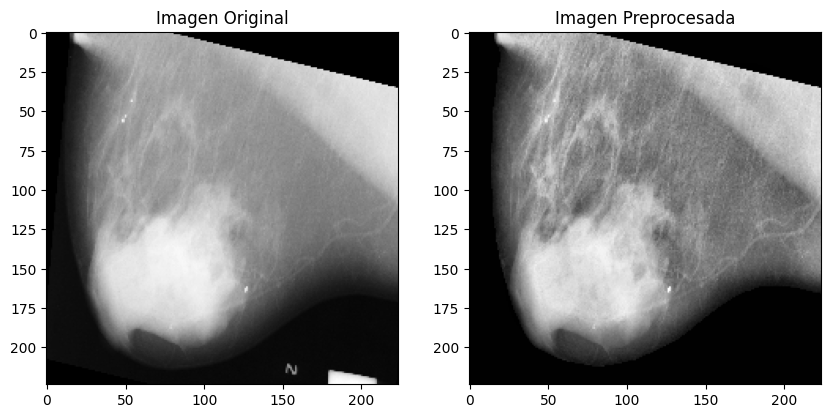

In [10]:

def filter_clahe(img):
    # Aplicar CLAHE para mejorar el contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    final_image = clahe.apply(img)
    return final_image

clahe_img = filter_clahe(nose_img)

img_compar(img,clahe_img)

In [11]:
# Leer las imagenes originales con sus etiquetas

imgs, labels = read_imageResize_with_labels(dir='../datasets/dataset')

In [12]:
# Comprobar la cantidad
print(imgs.shape)
print(len(labels))

(4643, 224, 224)
4643


In [13]:
# Verificar normalizacion
unicos = np.unique(imgs[0])
max(unicos)

255

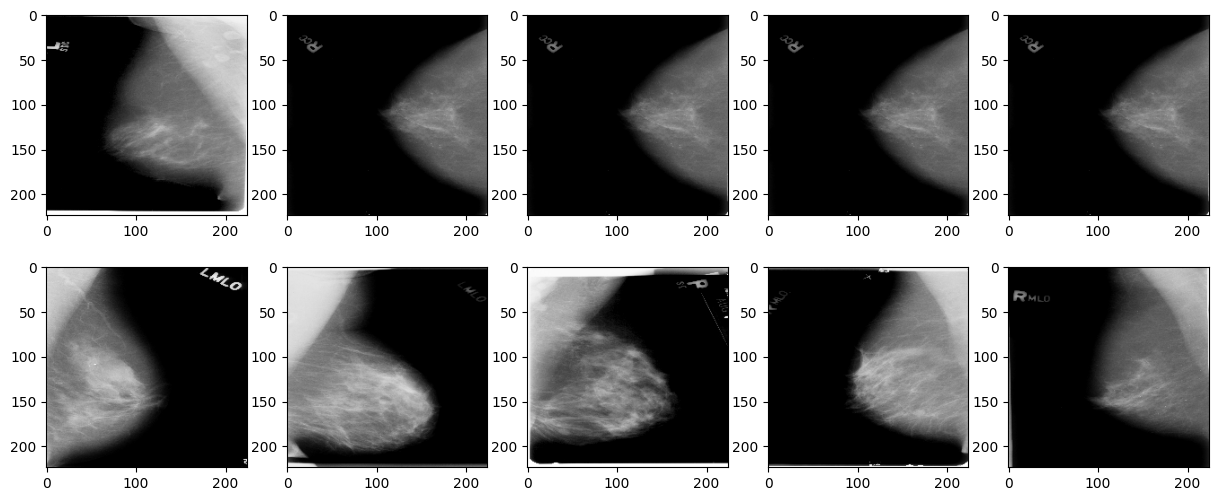

In [14]:
def show_imgs(imgs):
    '''
    Muestra una lista de imágenes en una matriz de 2 filas y 5 columnas utilizando Matplotlib.

    Parametros:
    - imgs: Una lista de matrices numpy representando las imágenes a mostrar.
    
    Esta función crea una figura con subtramas dispuestas en una matriz de 2x5.
    Recorre la lista de imágenes y las muestra en estas subtramas. Si hay menos de
    10 imágenes en la lista, los espacios restantes en la matriz quedan en blanco.
    '''
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(2):
        for j in range(5):
            if i*5 + j < len(imgs):
                axes[i, j].imshow(imgs[i*5 + j],cmap = 'gray')
                #axes[i, j].axis('off')

    plt.show()
    
show_imgs(imgs)

In [15]:
def images_processor(imgs):
    imgs_processor = []
    for img in imgs:
        threshold_img = gaussian_and_tresholdA(img)
        morphology = filter_morph_open(threshold_img)
        cleaned_img = extract_largest_component(morphology,threshold_img,img)
        normal_img = cleaned_img / 255
        imgs_processor.append(normal_img)
        #clahe_img = aplicar_clahe(cleaned_img)
    return np.array(imgs_processor)


imgs_processor = images_processor(imgs)


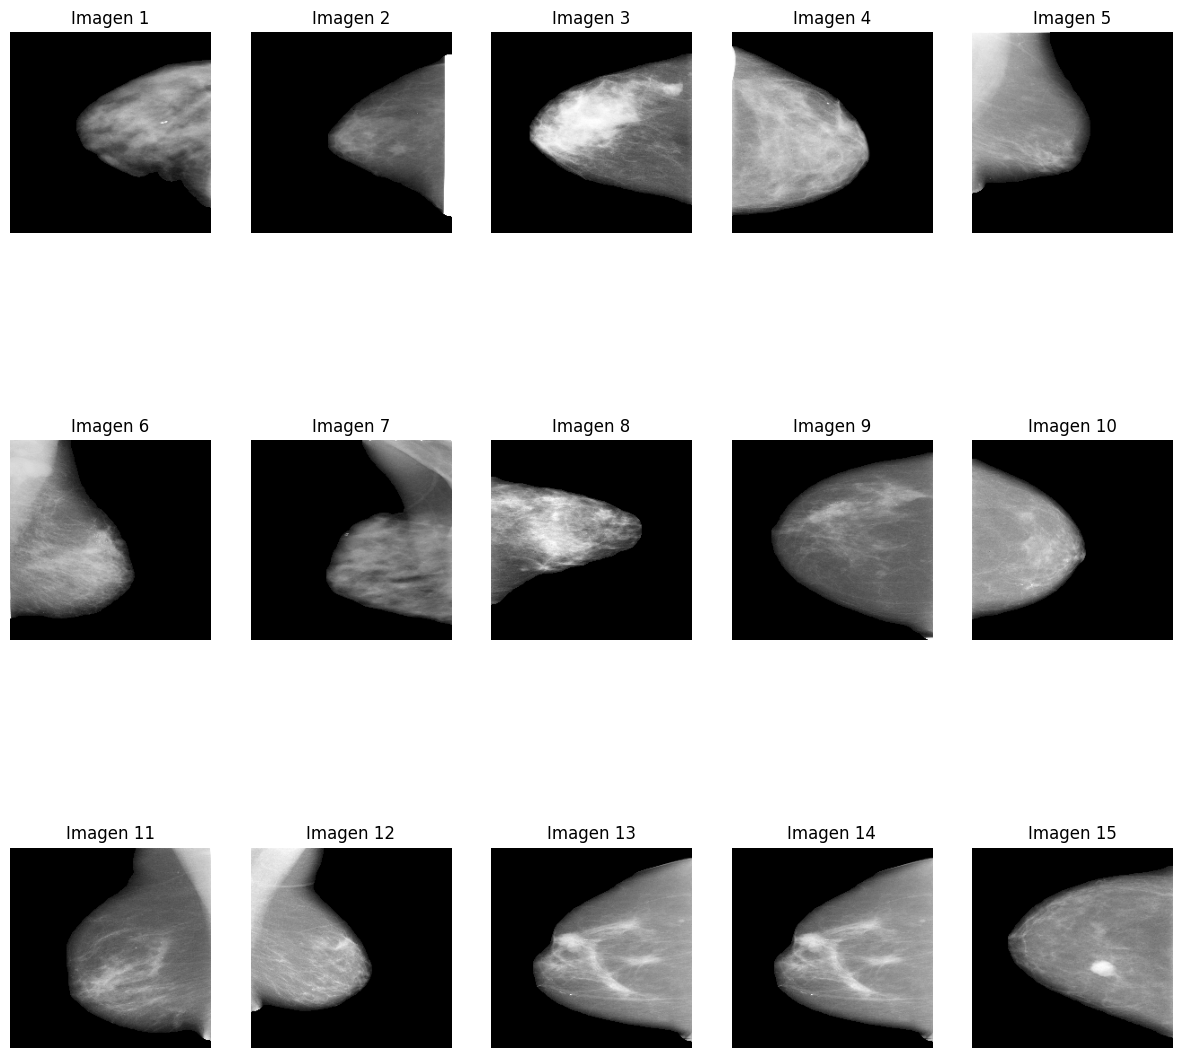

In [18]:
import matplotlib.pyplot as plt

# Función para mostrar imágenes
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Muestra la imagen y establece el título
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')  # Desactiva los ejes
        else:
            ax.axis('off')  # Desactiva los ejes de los subplots vacíos

# Títulos para las imágenes
titles = ['Imagen ' + str(i+1) for i in range(15)]

# Graficar las primeras 15 imágenes
plot_images(imgs_processor[2000:2015], titles, rows=3, cols=5)

plt.show()


Dado la comparación de las imágenes con filtro gaussiano y las originales del dataset, se decide no aplicar este filtro ya que el suavisado produce que las imágenes de vean borrosas, a diferencias de lo hecho con CLAHE que aumente el contraste de la imagen

In [19]:
unique_labels, unique_counts = np.unique(labels, return_counts=True)

# Crea un diccionario con las etiquetas y sus conteos
labels_histogram = dict(zip(unique_labels, unique_counts))

print(labels_histogram)

{0: 1242, 1: 1995, 2: 1406}


In [20]:
image_data = np.array(imgs_processor)
labels = np.array(labels)



X_train=[]
X_test=[]
y_train=[]
y_test = []



In [21]:
######### por si se prueba con transfer learning
#imagenes_rgb = []
#for imagen_gris in image_data:
    # Convertir la imagen de escala de grises a RGB
    #imagen_rgb = cv2.cvtColor(imagen_gris, cv2.COLOR_GRAY2RGB)
    # Agregar la imagen convertida a la lista
    #imagenes_rgb.append(imagen_rgb)
#imagenes_rgb = np.array(imagenes_rgb)

In [22]:

# Dividir en conjuntos de entrenamiento (70%) y temporal (30%), manteniendo el balance de etiquetas
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.3, stratify=labels, random_state=42)

# Dividir el conjunto temporal en validación y prueba, manteniendo el balance de etiquetas
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

from collections import Counter 
# Verificar las proporciones en los conjuntos de entrenamiento, validación y prueba
print("Proporciones en el conjunto de entrenamiento:", Counter(y_train))
print("Proporciones en el conjunto de validación:", Counter(y_val))
print("Proporciones en el conjunto de prueba:", Counter(y_test))


Proporciones en el conjunto de entrenamiento: Counter({1: 1397, 2: 984, 0: 869})
Proporciones en el conjunto de validación: Counter({1: 299, 2: 211, 0: 186})
Proporciones en el conjunto de prueba: Counter({1: 299, 2: 211, 0: 187})


In [23]:
print(type(X_train))

<class 'numpy.ndarray'>


In [24]:
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (3250, 224, 224)
Forma de X_val: (696, 224, 224)
Forma de X_test: (697, 224, 224)
Forma de y_train: (3250,)
Forma de y_val: (696,)
Forma de y_test: (697,)


In [25]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val,axis=-1)


# Verifica las nuevas formas
print(f"Nueva forma de datos de entrenamiento: {X_train.shape}")
print(f"Nueva forma de datos de prueba: {X_test.shape}")
print(f"Nueva forma de datos de validacion: {X_test.shape}")

Nueva forma de datos de entrenamiento: (3250, 224, 224, 1)
Nueva forma de datos de prueba: (697, 224, 224, 1)
Nueva forma de datos de validacion: (697, 224, 224, 1)


In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# Convertir las etiquetas a codificación one-hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)

# Crea generadores de datos de imagen con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255  # Reescala las imágenes por el factor dado
)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

# Crea generadores que suministrarán los datos al modelo durante el entrenamiento
train_generator = train_datagen.flow(
    X_train,
    y_train_one_hot,
    batch_size=32
)

test_generator = test_datagen.flow(
    X_test,
    y_test_one_hot,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val,
    y_val_one_hot,
    batch_size=32
)


In [27]:
print(y_val)

[1 1 1 0 2 0 1 0 1 2 2 1 0 2 1 0 0 2 1 1 2 0 1 0 1 1 1 1 1 2 2 1 0 0 1 2 1
 1 2 0 2 1 1 2 0 1 0 1 1 0 0 1 1 2 0 0 2 1 0 1 1 1 0 1 0 2 1 2 1 0 1 1 2 1
 0 1 1 1 1 1 1 0 1 0 2 2 2 0 0 2 1 2 0 2 1 1 1 1 2 0 2 1 1 2 2 0 1 2 1 2 1
 2 2 1 0 0 2 2 1 0 0 1 0 1 2 1 0 1 2 1 0 2 0 1 0 1 2 2 2 1 0 0 1 2 2 2 0 2
 0 0 1 1 2 1 1 2 2 0 0 2 1 1 2 2 1 2 2 2 1 2 1 1 1 2 2 2 1 2 0 0 0 2 0 2 2
 0 2 0 1 1 2 0 1 2 1 1 2 0 2 0 2 1 1 1 2 1 0 1 0 0 2 2 0 0 1 0 1 2 2 0 1 2
 0 2 1 2 0 1 2 1 1 2 1 2 1 2 2 1 1 0 1 2 1 0 1 0 0 2 1 1 0 1 1 1 1 2 1 2 0
 1 1 0 1 0 2 2 0 2 1 1 0 0 0 1 2 2 1 1 2 2 1 1 1 0 2 1 2 0 2 0 1 2 2 2 0 1
 0 1 0 1 2 2 1 0 1 0 1 0 2 1 0 2 1 1 1 1 1 1 0 1 2 2 0 1 1 2 2 0 1 1 0 1 1
 0 0 0 1 0 1 1 0 0 0 0 2 1 1 0 2 1 2 0 1 0 2 0 2 1 0 0 0 0 1 2 0 2 1 2 2 0
 2 0 2 1 1 1 1 1 1 1 0 1 2 0 1 2 0 0 1 2 1 1 2 1 2 2 1 2 1 1 2 0 0 2 2 1 0
 0 1 1 0 1 0 2 2 0 1 1 1 2 2 1 1 1 0 0 0 2 2 1 1 1 2 2 1 2 1 0 2 2 1 1 1 2
 0 2 0 2 0 1 2 0 0 1 1 1 2 2 2 0 1 2 1 0 0 1 1 2 0 1 0 0 2 2 2 1 1 1 1 2 0
 1 1 0 2 1 1 1 2 1 0 1 1 

In [28]:
print("GPUs disponibles: ", tf.config.list_physical_devices('GPU'))

GPUs disponibles:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
#Early stopping para que se detenga el entranamiento si a las 5 épocas no mejora el accuracy

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)


In [30]:

# callback para detener el entrenamiento si se alcanza el accuracy deseado
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.84):
      print("Accuracy alcanzado")
      self.model.stop_training = True


In [64]:
model = Sequential()

# Agregar la primera capa convolucional
model.add(Conv2D(32, (3, 3), strides=(2, 2), activation='relu', input_shape=(224, 224, 1)))

# Agregar la primera capa de MaxPooling
model.add(MaxPooling2D((3, 3), strides=(3, 3)))

# Agregar la segunda capa convolucional
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation='relu'))

# Agregar dos capas convolucionales más
model.add(Conv2D(64, (3, 3), activation='relu'))

# Agregar la segunda capa de MaxPooling
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Agregar tres capas convolucionales más
#for _ in range(3):
model.add(Conv2D(128, (3, 3), activation='sigmoid'))

# Aplanar los mapas de características
model.add(Flatten())

# Agregar una capa completamente conectada (Fully Connected) con 1024 neuronas
#model.add(Dense(1024, activation='relu'))

# Agregar la capa de salida con 2 neuronas (para la clasificación binaria)
model.add(Dense(3, activation='softmax'))

In [65]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 111, 111, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 6, 6, 128)        

In [66]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
stop = myCallback()
with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                        epochs=30,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping,stop])

Epoch 1/30
102/102 [==============================] - 6s 41ms/step - loss: 1.1875 - accuracy: 0.3769 - val_loss: 1.1110 - val_accuracy: 0.4296
Epoch 2/30
102/102 [==============================] - 4s 36ms/step - loss: 1.0851 - accuracy: 0.4160 - val_loss: 1.0790 - val_accuracy: 0.4296
Epoch 3/30
102/102 [==============================] - 4s 35ms/step - loss: 1.0789 - accuracy: 0.4298 - val_loss: 1.0765 - val_accuracy: 0.4296
Epoch 4/30
102/102 [==============================] - 3s 33ms/step - loss: 1.0766 - accuracy: 0.4298 - val_loss: 1.0679 - val_accuracy: 0.4296
Epoch 5/30
102/102 [==============================] - 3s 30ms/step - loss: 1.0490 - accuracy: 0.4292 - val_loss: 0.9532 - val_accuracy: 0.6221
Epoch 6/30
102/102 [==============================] - 3s 33ms/step - loss: 0.7170 - accuracy: 0.6289 - val_loss: 0.6472 - val_accuracy: 0.6422
Epoch 7/30
102/102 [==============================] - 3s 30ms/step - loss: 0.6555 - accuracy: 0.6465 - val_loss: 0.6522 - val_accuracy: 0.6250

In [68]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

22/22 [==============================] - 3s 113ms/step - loss: 0.6248 - accuracy: 0.6786
Test Accuracy: 0.6786226630210876


In [46]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [47]:
# Visualización de curvas de pérdida y precisión
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    
    plt.show()

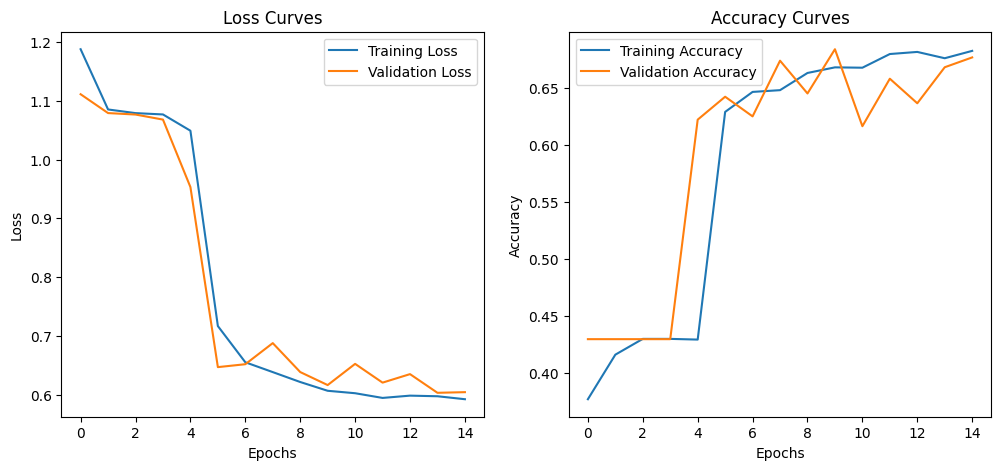

In [69]:
plot_training_history(history)

In [39]:
from sklearn.metrics import roc_curve, auc, recall_score,f1_score
import matplotlib.pyplot as plt

# Use the trained model to predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Convert y_pred_prob to a 1-dimensional array if it's 2-dimensional with only one column
if y_pred_prob.shape[1] == 1:
    y_pred_prob = y_pred_prob.ravel()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f'AUC: {roc_auc:.2f}')


22/22 [==============================] - 1s 15ms/step


ValueError: multiclass format is not supported

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(X_test)

# Paso 4: Convierte las probabilidades en etiquetas de clase usando un umbral de 0.5
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)

# Paso 5: Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Paso 6: Muestra la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

# Paso 7: Visualiza la matriz de confusión usando una gráfica de calor (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred. Negativo', 'Pred. Positivo'], yticklabels=['Real Negativo', 'Real Positivo'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

22/22 [==============================] - 1s 21ms/step


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [71]:
# Calcular recall y F-score
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets